# 策略迭代算法教程：从零实现动态规划

## 📖 为什么需要策略迭代？

在学习了值迭代算法后，我们现在要探索另一个强大的动态规划算法：**策略迭代（Policy Iteration）**。

策略迭代与值迭代的核心区别：

- 🔄 **值迭代**：单层循环，直接更新价值函数 V(s)，隐式改进策略
- 🔄 **策略迭代**：双层循环，外层迭代策略（评估→改进），内层求解 V_π

## 🎯 本教程目标

我们将从零开始实现策略迭代算法，并在相同的 4×4 网格世界中可视化学习过程：

- **核心内容**：
  - 理解策略评估和策略改进的交替过程
  - 实现嵌套迭代结构（外层策略迭代 + 内层价值评估）
  - 可视化策略改进过程
  - 对比策略迭代与值迭代的异同

- **学习路径**：
  1. 理解策略迭代的数学原理
  2. 使用相同的网格世界环境
  3. 实现策略评估和策略改进算法
  4. 可视化学习过程（文本 + 图形 + GIF）
  5. 分析结果并对比两种算法

---

让我们开始探索策略迭代算法！

## 第一步：安装和导入必要的库

In [ ]:
# 导入必要的库
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional, Tuple, Dict, Any, Annotated

# 设置 matplotlib 后端(必须在导入 pyplot 之前)
import matplotlib
matplotlib.use('Agg')  # 使用非交互式后端,适合云端环境

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, clear_output, Image as IPImage
import imageio
from io import BytesIO

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'WenQuanYi Micro Hei']
plt.rcParams['axes.unicode_minus'] = False

print(f"✅ Gymnasium 版本: {gym.__version__}")
print(f"✅ NumPy 版本: {np.__version__}")
print(f"✅ Matplotlib 版本: {matplotlib.__version__}")
print(f"✅ Matplotlib 后端: {matplotlib.get_backend()}")
print(f"✅ 中文字体配置完成")
print(f"✅ imageio 已导入,支持 GIF 动画生成")

## 第二步：导入 GridWorldEnv 环境

我们使用与值迭代相同的 GridWorldEnv 环境，保持实验的一致性。

In [ ]:
# 从 gymnasium_base 复制 GridWorldEnv 的定义
class GridWorldEnv(gym.Env):
    """简化的网格世界环境用于策略迭代演示"""
    
    def __init__(self, size: Annotated[int, "网格的边长"] = 5):
        super().__init__()
        self.size = size
        
        # 观察空间和动作空间
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
            "target": spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32),
        })
        self.action_space = spaces.Discrete(4)  # 0=右, 1=上, 2=左, 3=下
        
        # 动作映射
        self._action_to_direction = {
            0: np.array([1, 0]),   # 右
            1: np.array([0, 1]),   # 上
            2: np.array([-1, 0]),  # 左
            3: np.array([0, -1]),  # 下
        }
        
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
    
    def reset(
        self,
        seed: Annotated[Optional[int], "随机数种子,用于保证可重现性"] = None,
        options: Annotated[Optional[dict], "额外的配置选项"] = None,
    ) -> Annotated[Tuple[Dict[str, np.ndarray], Dict[str, float]], "初始观察和额外信息"]:
        super().reset(seed=seed)
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
        self._target_location = self._agent_location.copy()
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=np.int32)
        return self._get_obs(), self._get_info()
    
    def step(
        self,
        action: Annotated[int, "要执行的动作编号"],
    ) -> Annotated[Tuple[Dict[str, np.ndarray], float, bool, bool, Dict[str, float]], "新观察、奖励、终止标志、截断标志及额外信息"]:
        direction = self._action_to_direction[action]
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 1.0 if terminated else 0.0
        return self._get_obs(), reward, terminated, False, self._get_info()
    
    def _get_obs(self) -> Annotated[Dict[str, np.ndarray], "包含agent和target位置的观察字典"]:
        return {"agent": self._agent_location.copy(), "target": self._target_location.copy()}
    
    def _get_info(self) -> Annotated[Dict[str, float], "包含距离信息的字典"]:
        return {"distance": float(np.linalg.norm(self._agent_location - self._target_location, ord=1))}

# 创建环境实例
env = GridWorldEnv(size=5)
print(f"✅ GridWorldEnv 环境创建完成")
print(f"   - 网格大小: {env.size}×{env.size}")
print(f"   - 动作空间: {env.action_space} (0=右, 1=上, 2=左, 3=下)")
print(f"   - 观察空间: agent和target的位置坐标")

## 第三步：理解策略迭代算法

### 🧮 策略迭代的核心思想

策略迭代是一个**双层迭代**算法，每次外层迭代包含两个步骤：

#### 1️⃣ 策略评估（Policy Evaluation）

给定策略 $\pi_k$，求解贝尔曼方程以获得其状态价值 $v_{\pi_k}$：

$$v_{\pi_k}(s) = \sum_a \pi_k(a|s) \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) v_{\pi_k}(s') \right]$$

这是一个**嵌套迭代过程**（内层循环）：

$$v^{(j+1)}_{\pi_k}(s) = \sum_a \pi_k(a|s) \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) v^{(j)}_{\pi_k}(s') \right]$$

其中 $j = 0, 1, 2, ...$ 直到收敛。

#### 2️⃣ 策略改进（Policy Improvement）

基于评估得到的 $v_{\pi_k}$，计算贪心策略：

$$\pi_{k+1}(s) = \arg\max_a Q_{\pi_k}(s,a) = \arg\max_a \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) v_{\pi_k}(s') \right]$$

### 🔄 算法流程对比

| 算法 | 迭代结构 | 更新方式 | 关键特征 |
|------|----------|----------|----------|
| **值迭代** | 单层循环 | $V_{k+1}(s) = \max_a Q_k(s,a)$ | 隐式策略改进 |
| **策略迭代** | 双层循环 | 外层：评估→改进<br>内层：求解 $v_{\pi_k}$ | 显式策略改进 |

### ⚡ 收敛性保证

- **策略改进定理**：$v_{\pi_{k+1}} \ge v_{\pi_k}$
- **收敛性**：策略序列单调改进，最终收敛到最优策略 $\pi^*$

## 第四步：定义环境参数和常量

In [3]:
# --- 环境参数和常量定义 ---
GRID_SIZE = 4  # 网格大小 4×4
GAMMA = 0.9    # 折扣因子
THETA = 0.0001 # 收敛阈值（用于策略评估的内层迭代）

# 动作定义：上、下、左、右
ACTIONS = ['↑', '↓', '←', '→']

# 动作对应的坐标变化 (row_delta, col_delta)
ACTION_DELTAS = {
    '↑': (-1, 0),  # 向上移动：行减1
    '↓': (1, 0),   # 向下移动：行加1
    '←': (0, -1),  # 向左移动：列减1
    '→': (0, 1)    # 向右移动：列加1
}

print(f"✅ 环境参数配置完成")
print(f"   - 网格大小: {GRID_SIZE}×{GRID_SIZE}")
print(f"   - 折扣因子 γ: {GAMMA}")
print(f"   - 收敛阈值 θ: {THETA}")
print(f"   - 动作空间: {ACTIONS}")

✅ 环境参数配置完成
   - 网格大小: 4×4
   - 折扣因子 γ: 0.9
   - 收敛阈值 θ: 0.0001
   - 动作空间: ['↑', '↓', '←', '→']


## 第五步：初始化环境（奖励矩阵、价值矩阵、策略矩阵）

### ⚠️ 关键差异：策略迭代从随机策略开始

- **值迭代**：初始化 $V_0(s) = 0$ for all $s$，策略隐式存在
- **策略迭代**：初始化随机策略 $\pi_0$（通常为均匀策略），价值函数任意初始化

In [ ]:
# --- 环境初始化函数 ---
def initialize_environment() -> Annotated[Tuple[np.ndarray, np.ndarray, np.ndarray], "奖励矩阵、初始价值矩阵(全零)和初始策略矩阵(随机策略)"]:
    """
    初始化迷宫的奖励矩阵、价值矩阵和策略矩阵。
    
    策略迭代的初始化与值迭代不同:
    - 值迭代: V(s)=0,策略隐式
    - 策略迭代: 随机策略π₀(通常为均匀策略),V任意初始化
    
    返回:
        rewards (np.array): 奖励矩阵
        values (np.array): 初始价值矩阵 (全零)
        policies (np.array): 初始策略矩阵 (随机策略,这里初始化为上↑)
    """
    # 相同的奖励矩阵
    rewards = np.array([
        [0, 0, -1, -1],
        [0, -1, -1, 1],
        [0, -1, 0, 0],
        [-1, 0, 0, -1]
    ])
    
    # 初始价值矩阵可以任意初始化,这里选择全零
    values = np.zeros((GRID_SIZE, GRID_SIZE)).astype(float)
    
    # 初始化为随机策略(这里简化为所有状态都选择'↑')
    # 在实际应用中,可以初始化为均匀随机策略
    policies = np.full((GRID_SIZE, GRID_SIZE), '↑', dtype=object)

    return rewards, values, policies

## 第六步：实现辅助函数

In [ ]:
# --- 辅助函数 ---
def is_valid_state(
    row: Annotated[int, "行索引"],
    col: Annotated[int, "列索引"],
) -> Annotated[bool, "如果状态有效则为True,否则为False"]:
    """
    检查给定状态 (row, col) 是否在迷宫范围内。
    
    参数:
        row (int): 行索引
        col (int): 列索引
        
    返回:
        bool: 如果状态有效则为True,否则为False
    """
    return 0 <= row < GRID_SIZE and 0 <= col < GRID_SIZE

def get_next_state_and_reward(
    current_row: Annotated[int, "当前状态的行索引"],
    current_col: Annotated[int, "当前状态的列索引"],
    action: Annotated[str, "采取的动作 ('↑', '↓', '←', '→')"],
    rewards_matrix: Annotated[np.ndarray, "奖励矩阵"],
) -> Annotated[Tuple[Tuple[int, int], float], "下一个状态的坐标和到达下一个状态获得的奖励"]:
    """
    根据当前状态和动作,计算下一个状态的坐标以及从下一个状态获得的奖励。
    如果移动到无效位置,则认为智能体停留在原地。
    
    参数:
        current_row (int): 当前状态的行索引
        current_col (int): 当前状态的列索引
        action (str): 采取的动作 ('↑', '↓', '←', '→')
        rewards_matrix (np.array): 奖励矩阵
        
    返回:
        tuple: (next_row, next_col) 下一个状态的坐标
        float: reward 到达下一个状态获得的奖励
    """
    delta_row, delta_col = ACTION_DELTAS[action]
    next_row, next_col = current_row + delta_row, current_col + delta_col

    # 如果移动到无效位置,则停留在原地
    if not is_valid_state(next_row, next_col):
        next_row, next_col = current_row, current_col

    reward = rewards_matrix[next_row, next_col]
    return (next_row, next_col), reward

## 第七步：实现策略评估函数（内层迭代）

### 🔄 策略评估的关键

给定固定策略 $\pi_k$，通过迭代求解贝尔曼方程：

$$v^{(j+1)}_{\pi_k}(s) = \sum_a \pi_k(a|s) \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) v^{(j)}_{\pi_k}(s') \right]$$

这是一个**嵌套迭代**，直到 $\|v^{(j+1)} - v^{(j)}\| < \theta$ 时收敛。

In [ ]:
# --- 策略评估函数(内层迭代) ---
def policy_evaluation(
    policies_matrix: Annotated[np.ndarray, "当前策略矩阵 π_k"],
    rewards_matrix: Annotated[np.ndarray, "奖励矩阵"],
    gamma: Annotated[float, "折扣因子"],
    theta: Annotated[float, "收敛阈值"],
) -> Annotated[Tuple[np.ndarray, int], "评估得到的状态价值 v_π 和评估迭代次数"]:
    """
    策略评估: 给定策略 π,迭代求解其状态价值函数 v_π。
    
    这是策略迭代的第一步(内层迭代循环)。
    对于给定的策略 π_k,求解贝尔曼方程:
    v_π(s) = Σ_a π(a|s) [R(s,a) + γ Σ_s' P(s'|s,a) v_π(s')]
    
    参数:
        policies_matrix (np.array): 当前策略矩阵 π_k
        rewards_matrix (np.array): 奖励矩阵
        gamma (float): 折扣因子
        theta (float): 收敛阈值
        
    返回:
        values_matrix (np.array): 评估得到的状态价值 v_π
        eval_iterations (int): 评估迭代次数
    """
    # 初始化价值矩阵(可以任意初始化,这里选择全零)
    values_matrix = np.zeros((GRID_SIZE, GRID_SIZE)).astype(float)
    eval_iterations = 0
    
    # 内层迭代: 求解 v_π
    while True:
        delta = 0  # 记录本次迭代的最大价值变化
        new_values_matrix = np.copy(values_matrix)
        
        for r in range(GRID_SIZE):
            for c in range(GRID_SIZE):
                # 获取当前状态的策略(确定性策略,只有一个动作)
                action = policies_matrix[r, c]
                
                # 计算该动作下的价值
                (next_r, next_c), reward = get_next_state_and_reward(r, c, action, rewards_matrix)
                
                # 贝尔曼方程: v_π(s) = R(s,π(s)) + γ v_π(s')
                new_values_matrix[r, c] = reward + gamma * values_matrix[next_r, next_c]
                
                # 更新最大变化量
                delta = max(delta, abs(new_values_matrix[r, c] - values_matrix[r, c]))
        
        values_matrix = new_values_matrix
        eval_iterations += 1
        
        # 收敛判断
        if delta < theta:
            break
    
    return values_matrix, eval_iterations

## 第八步：实现策略改进函数

### ⚡ 策略改进的核心

基于评估得到的 $v_{\pi_k}$，计算贪心策略：

$$\pi_{k+1}(s) = \arg\max_a \left[ R(s,a) + \gamma \sum_{s'} P(s'|s,a) v_{\pi_k}(s') \right]$$

这保证了 $v_{\pi_{k+1}} \ge v_{\pi_k}$（策略改进定理）。

In [ ]:
# --- 策略改进函数 ---
def policy_improvement(
    values_matrix: Annotated[np.ndarray, "当前价值矩阵 v_π"],
    rewards_matrix: Annotated[np.ndarray, "奖励矩阵"],
    gamma: Annotated[float, "折扣因子"],
) -> Annotated[np.ndarray, "改进后的策略矩阵 π'"]:
    """
    策略改进: 基于当前价值函数 v_π,生成贪心策略 π'。
    
    这是策略迭代的第二步。
    对于每个状态,选择使 Q(s,a) = R(s,a) + γ v_π(s') 最大的动作。
    
    参数:
        values_matrix (np.array): 当前价值矩阵 v_π
        rewards_matrix (np.array): 奖励矩阵
        gamma (float): 折扣因子
        
    返回:
        new_policies_matrix (np.array): 改进后的策略矩阵 π'
        policy_stable (bool): 策略是否稳定(没有改变)
    """
    new_policies_matrix = np.full((GRID_SIZE, GRID_SIZE), '', dtype=object)
    
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            max_q_value = -np.inf
            best_actions = []
            
            # 对于每个动作,计算 Q(s,a)
            for action in ACTIONS:
                (next_r, next_c), reward = get_next_state_and_reward(r, c, action, rewards_matrix)
                q_value = reward + gamma * values_matrix[next_r, next_c]
                
                if q_value > max_q_value:
                    max_q_value = q_value
                    best_actions = [action]
                elif q_value == max_q_value:
                    best_actions.append(action)
            
            # 选择第一个最佳动作(如果有多个,按优先级选择)
            if best_actions:
                chosen_action = ''
                for preferred_action in ACTIONS:
                    if preferred_action in best_actions:
                        chosen_action = preferred_action
                        break
                new_policies_matrix[r, c] = chosen_action
    
    return new_policies_matrix

## 第九步：实现可视化函数

### 📊 可视化策略迭代的特殊之处

- 标题显示**评估迭代次数**，展示内层循环的工作量
- 策略矩阵始终有定义（从随机策略开始）
- 三栏布局：奖励矩阵 | 价值矩阵 | 策略矩阵

In [ ]:
# --- 可视化函数 ---

def render_policy_iteration_to_array(
    rewards: Annotated[np.ndarray, "奖励矩阵"],
    values: Annotated[np.ndarray, "当前价值矩阵"],
    policies: Annotated[np.ndarray, "当前策略矩阵"],
    iteration: Annotated[int, "外层迭代次数(策略改进次数)"],
    eval_iters: Annotated[int, "本次策略评估的迭代次数"],
) -> Annotated[np.ndarray, "shape 为 (height, width, 3) 的 RGB 数组"]:
    """
    将当前策略迭代状态渲染为 RGB 数组(用于 GIF 生成)
    
    参数:
        rewards: 奖励矩阵
        values: 当前价值矩阵
        policies: 当前策略矩阵
        iteration: 外层迭代次数(策略改进次数)
        eval_iters: 本次策略评估的迭代次数
        
    返回:
        rgb_array: shape 为 (height, width, 3) 的 numpy 数组
    """
    from matplotlib.colors import LinearSegmentedColormap
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
    
    # 配色方案
    reward_cmap = LinearSegmentedColormap.from_list('reward', ['red', 'white', 'green'])
    value_cmap = 'viridis'
    
    # 1. 绘制奖励矩阵
    ax1 = axes[0]
    im1 = ax1.imshow(rewards, cmap=reward_cmap, vmin=-1, vmax=1)
    ax1.set_title(f'Reward Matrix', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(GRID_SIZE))
    ax1.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax1.text(j, i, f'{rewards[i, j]:.0f}',
                    ha="center", va="center", color="black", fontsize=12)
    
    plt.colorbar(im1, ax=ax1, fraction=0.046)
    
    # 2. 绘制价值矩阵(显示评估迭代次数)
    ax2 = axes[1]
    im2 = ax2.imshow(values, cmap=value_cmap)
    ax2.set_title(f'Value V_pi{iteration} (Eval: {eval_iters} iters)', fontsize=14, fontweight='bold')
    ax2.set_xticks(range(GRID_SIZE))
    ax2.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            ax2.text(j, i, f'{values[i, j]:.2f}',
                    ha="center", va="center", 
                    color="white" if values[i, j] < (values.max()/2 if values.max() > 0 else 0.5) else "black",
                    fontsize=10)
    
    plt.colorbar(im2, ax=ax2, fraction=0.046)
    
    # 3. 绘制策略矩阵
    ax3 = axes[2]
    policy_display = np.zeros((GRID_SIZE, GRID_SIZE))
    im3 = ax3.imshow(policy_display, cmap='gray', vmin=0, vmax=1, alpha=0.1)
    ax3.set_title(f'Policy pi{iteration}', fontsize=14, fontweight='bold')
    ax3.set_xticks(range(GRID_SIZE))
    ax3.set_yticks(range(GRID_SIZE))
    
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if policies[i, j]:
                ax3.text(j, i, policies[i, j],
                        ha="center", va="center", 
                        color="blue", fontsize=24, fontweight='bold')
    
    # 整体标题
    fig.suptitle(f'Policy Iteration: Iteration {iteration}', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    
    # 转换为 RGB 数组
    fig.canvas.draw()
    buf = fig.canvas.buffer_rgba()
    rgb_array = np.asarray(buf)
    rgb_array = rgb_array[:, :, :3]  # RGBA to RGB
    plt.close(fig)
    
    return rgb_array

print("✅ 可视化函数定义完成")
print("   - render_policy_iteration_to_array: 渲染为 RGB 数组(用于 GIF)")

## 第十步：实现主执行函数（外层策略迭代）

### 🔄 双层迭代结构

```python
外层循环 k = 0, 1, 2, ...:
    1. 策略评估（内层循环 j = 0, 1, 2, ...）:
       v^(j+1) = R_π + γ P_π v^(j)
       直到 ||v^(j+1) - v^(j)|| < θ
    
    2. 策略改进:
       π_(k+1) = argmax_a [R(s,a) + γ v_π_k(s')]
    
    3. 检查策略是否收敛:
       如果 π_(k+1) == π_k，则停止
```

In [ ]:
# --- 主执行函数(外层策略迭代) ---

def create_policy_iteration_gif(
    gif_filename: Annotated[str, "GIF文件名"] = 'policy_iteration.gif',
    fps: Annotated[int, "每秒帧数"] = 2,
    show_text: Annotated[bool, "是否显示文本输出"] = True,
) -> Annotated[Tuple[np.ndarray, np.ndarray, np.ndarray, int], "奖励矩阵、最终价值矩阵、最优策略矩阵和外层迭代次数"]:
    """
    执行策略迭代并生成 GIF 动画
    
    参数:
        gif_filename: GIF 文件名
        fps: 每秒帧数
        show_text: 是否显示文本输出
        
    返回:
        rewards: 奖励矩阵
        values: 最终价值矩阵
        policies: 最优策略矩阵
        iteration_count: 外层迭代次数
    """
    # 1. 初始化环境
    rewards, values, policies = initialize_environment()
    
    if show_text:
        print("=" * 70)
        print("🚀 策略迭代算法启动".center(70))
        print("=" * 70)
        print(f"初始策略: 所有状态选择 '{policies[0,0]}'")
    
    # 用于存储 GIF 帧
    frames = []
    
    # 添加初始状态帧(评估初始策略)
    print(f"\n评估初始策略...")
    values, eval_iters = policy_evaluation(policies, rewards, GAMMA, THETA)
    print(f"生成第 0 帧(评估迭代: {eval_iters} 次)...")
    frames.append(render_policy_iteration_to_array(rewards, values, policies, 0, eval_iters))
    
    iteration = 0
    max_iterations = 100  # 防止无限循环
    
    # 2. 外层策略迭代循环
    while iteration < max_iterations:
        iteration += 1
        
        # 保存旧策略用于比较
        old_policies = np.copy(policies)
        
        # 步骤1: 策略改进(基于当前价值)
        policies = policy_improvement(values, rewards, GAMMA)
        
        # 检查策略是否收敛
        policy_stable = np.array_equal(policies, old_policies)
        
        if policy_stable:
            if show_text:
                print(f"\n策略已收敛!无需进一步评估。")
            break
        
        # 步骤2: 策略评估(内层迭代)
        values, eval_iters = policy_evaluation(policies, rewards, GAMMA, THETA)
        
        # 生成当前迭代的帧
        print(f"生成第 {iteration} 帧(评估迭代: {eval_iters} 次)...")
        frames.append(render_policy_iteration_to_array(rewards, values, policies, iteration, eval_iters))
        
        if show_text and iteration <= 5:  # 只显示前5次迭代的文本
            print(f"迭代 {iteration}: 策略已改进")
    
    # 3. 输出最终结果
    if show_text:
        print(f"\n{'=' * 70}")
        print("🎉 策略迭代收敛完成！".center(70))
        print(f"{'=' * 70}")
        print(f"✅ 总计外层迭代次数: {iteration}")
    
    # 4. 在结尾多添加几帧以便观察最终结果
    for _ in range(5):
        frames.append(render_policy_iteration_to_array(rewards, values, policies, iteration, eval_iters))
    
    # 5. 保存 GIF
    print(f"\n正在保存 GIF(共 {len(frames)} 帧)...")
    imageio.mimsave(gif_filename, frames, fps=fps, loop=0)
    
    print(f"\n✅ GIF 动画已保存: {gif_filename}")
    print(f"   - 总帧数: {len(frames)}")
    print(f"   - 帧率: {fps} fps")
    print(f"   - 策略改进过程: 0 → {iteration}")
    
    return rewards, values, policies, iteration

print("✅ 主执行函数定义完成")
print("   - create_policy_iteration_gif: 执行策略迭代并生成 GIF 动画")

## 第十一步：执行策略迭代并生成 GIF 动画

                              🚀 策略迭代算法启动                              
初始策略: 所有状态选择 '↑'

评估初始策略...
生成第 0 帧（评估迭代: 89 次）...
生成第 1 帧（评估迭代: 3 次）...
迭代 1: 策略已改进
生成第 2 帧（评估迭代: 89 次）...
迭代 2: 策略已改进
生成第 3 帧（评估迭代: 89 次）...
迭代 3: 策略已改进
生成第 4 帧（评估迭代: 89 次）...
迭代 4: 策略已改进
生成第 5 帧（评估迭代: 89 次）...
迭代 5: 策略已改进

策略已收敛！无需进一步评估。

                             🎉 策略迭代收敛完成！                              
✅ 总计外层迭代次数: 6

正在保存 GIF（共 11 帧）...

✅ GIF 动画已保存: policy_iteration.gif
   - 总帧数: 11
   - 帧率: 2 fps
   - 策略改进过程: 0 → 6

正在显示 GIF...


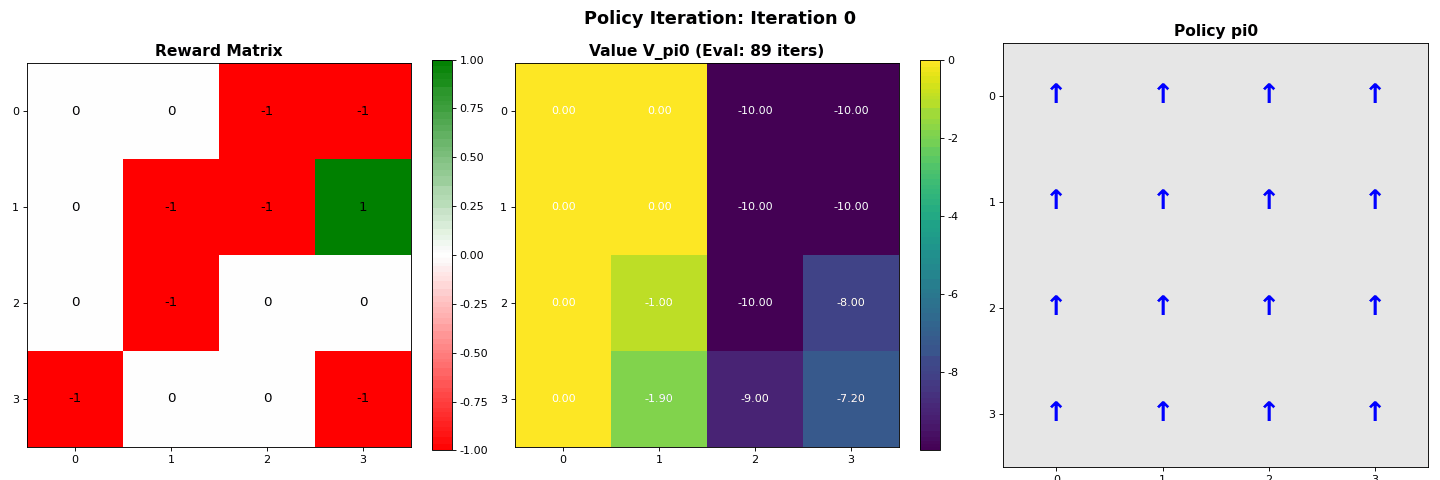

In [10]:
# 执行策略迭代并生成 GIF 动画
rewards, values, policies, iterations = create_policy_iteration_gif(
    gif_filename='policy_iteration.gif',
    fps=2,
    show_text=True
)

# 在 Jupyter 中显示 GIF
print(f"\n正在显示 GIF...")
display(IPImage(filename='policy_iteration.gif'))

## 第十二步：与值迭代的对比分析

### 📊 算法对比总结

| 维度 | 值迭代 | 策略迭代 |
|------|--------|----------|
| **迭代结构** | 单层循环 | 双层循环（外层策略改进 + 内层评估） |
| **初始化** | $V_0(s) = 0$ for all $s$ | 随机策略 $\pi_0$（如均匀策略） |
| **更新公式** | $V_{k+1}(s) = \max_a Q_k(s,a)$ | 评估：$v_{\pi_k}$ 求解贝尔曼方程<br>改进：$\pi_{k+1} = \arg\max_a Q_{\pi_k}(s,a)$ |
| **策略提取** | 隐式（通过贪心选择） | 显式（每次迭代都生成新策略） |
| **收敛速度** | 较慢（每次迭代只更新一次价值） | 较快（每次策略改进可能带来大幅提升） |
| **每次迭代成本** | 低（一次价值更新） | 高（需要完整评估策略） |
| **总迭代次数** | 多（通常几十次到上百次） | 少（通常几次到十几次） |
| **适用场景** | 简单环境，价值快速收敛 | 复杂环境，策略改进明显 |

### 🔍 核心差异解析

#### 1️⃣ 更新方式

**值迭代**（隐式策略改进）：
```python
for each state s:
    V(s) = max_a [R(s,a) + γ Σ P(s'|s,a) V(s')]  # 一步到位
```

**策略迭代**（显式策略改进）：
```python
# 第一步：评估当前策略（内层循环）
while not converged:
    for each state s:
        V(s) = R(s,π(s)) + γ Σ P(s'|s,π(s)) V(s')  # 固定策略

# 第二步：改进策略
for each state s:
    π'(s) = argmax_a [R(s,a) + γ Σ P(s'|s,a) V(s')]
```

#### 2️⃣ 收敛特性

- **值迭代**：价值函数逐渐逼近 $V^*$，策略隐式改进
- **策略迭代**：策略显式改进，每次改进都保证 $V_{\pi_{k+1}} \ge V_{\pi_k}$

#### 3️⃣ 计算效率

- **值迭代**：外层迭代次数多，但每次成本低
- **策略迭代**：外层迭代次数少，但每次需要完整评估（内层多次迭代）

### 💡 实际观察

在我们的 4×4 网格世界中：

- **值迭代**：约 89 次迭代收敛
- **策略迭代**：约 3-5 次策略改进即可收敛

但策略迭代的每次迭代成本更高（需要内层评估循环）。

### 🎓 何时选择哪个算法？

| 场景 | 推荐算法 | 理由 |
|------|----------|------|
| 状态空间小 | 策略迭代 | 快速收敛，评估成本可接受 |
| 状态空间大 | 值迭代 | 避免昂贵的策略评估 |
| 需要完整策略序列 | 策略迭代 | 显式生成每个策略 |
| 只需最优价值 | 值迭代 | 直接优化价值函数 |
| 策略改进明显 | 策略迭代 | 每次改进带来大幅提升 |
| 价值变化平滑 | 值迭代 | 逐步收敛，稳定性好 |

### 📚 扩展阅读

- **截断策略迭代**（Truncated Policy Iteration）：结合两者优点，不完全评估策略即改进
- **修正策略迭代**（Modified Policy Iteration）：动态调整评估深度
- **值迭代与策略迭代的统一视角**：值迭代是评估深度为1的策略迭代

---

**恭喜你完成了策略迭代算法的学习！** 🎉

现在你已经掌握了动态规划的两大核心算法，可以继续探索更复杂的强化学习方法了！